<center><h1>Clase 5 - Implementación FIR</h1></center>

En un forma general cualquier filtro FIR puede escribirse:
$$ y(n) = \sum_{k=0}^{M-1}h(k).x(n-k) $$

*Este tipo de filtros pueden realizarse siguiendo el siguiente esquematico:*
![PDS_CLASE_5_13](./PDS_CLASE_5_13.PNG)

### Esta arquitectura se conoce como Forma Directa

## Extensión de bits

La presición de la salida (sin truncamiento) queda determinada como la suma de la cantidad de bits de la entradas mas el factor de creciemiento G. Que para un FIR se calcula como:

$$ G \leq log_2(\sum_{k=0}^{M-1}(\vert h(k) \vert)) $$

Por ejemplo para el caos del siguiente filtro:

$$ h(n) = {-1;3;5;5;3;-1} $$

Este es un filtro del TIPO II, que es simetrico, con numero PAR de coeficientes en la respuesta impulsiva. Tiene reardo de grupo constante. Fase inicial igual a 0.

Para este filtro tenemos un G igual a 1 + 3 + 5 + 5 + 3 + 1 = 18 $log_2(18) = 4.16 < 5$

Esto implica que a la salida tenemos que agregar 5 bits.


## Simetria de coeficientes
Los filtros de fase lineal tienen la propiedad que sus coeficientes son simetricos o anti-simetricos:
$$h(n) = \pm h(M-1-n)$$
Para n = 0,1,......,M-1. Siendo M el orden de la respuesta impulsiva.

Entonces un filtro simtrico para M = 4, su salida siempre tendra el siguiente formato:

$$h(n) = h_0.x(n) + h_1.x(n-1) + h_1.x(n-2) + h_0.x(n-3) $$

Esto puede factorizarse para obtener los siguientes resultados:

$$h(n) = h_0.(x(n) + x(n-3)) + h_1.(x(n-1) + x(n-2))$$


![PDS_CLASE_5_14](./PDS_CLASE_5_14.PNG)

### Implementacion para FIR TIPO I (Simetrico,Numero Impar de coeficientes)
![PDS_CLASE_5_15](./PDS_CLASE_5_15.PNG)

**Para orden Impar las multiplicacion se reducen de M a $\frac{M}{2}+1$ y para orden Par las multiplicaciones se reducen a $\frac{M}{2}$**.
Si es antisimetrico se cambia la suma por una resta.

### Forma Traspuesta
**Se usa el teorema de mason de reversión de grafos. Si se cambian el sentido de todas las flechas, cambiando entradas por salidas y se substituyen las derivaciones en rams por sumadores y viceversa, se obtiene una transferencia identica a la original**

No es necesario agregar una linea extra de pipelina. La latencia introducida por la lógica combinacion es absorvida por los retardos.
Puede implicar mucho fan-out.

![PDS_CLASE_5_17](./PDS_CLASE_5_17.PNG)
![PDS_CLASE_5_18](./PDS_CLASE_5_18.PNG)

# DSP en Xilinx
## Dependiendo la aplicacion target uno puede adaptarse a multiples requerimientos
![PDS_CLASE_5_20](./PDS_CLASE_5_20.PNG)

## Arquitectura simplificada Arty Z7
![PDS_CLASE_5_20](./PDS_CLASE_5_22.PNG)

**Para poder realizar DSP Xilinx nos brinda en la serie 7 el siguiente bloque DSP**.
[Link DSP](https://www.xilinx.com/support/documentation/user_guides/ug479_7Series_DSP48E1.pdf)
![PDS_CLASE_5_21](./PDS_CLASE_5_21.PNG).

* Los tile estan ubicados en una columna de la FPGA, lo cual reduce el tiempo de ruteo.
* Preadder y multiplicador de 25x18.
* 638 MHz de frecuencia máxima.
* Redondeo.

## Pre-Adder
![PDS_CLASE_5_24](./PDS_CLASE_5_24.PNG).
## Explota la simetria de los filtros de fase lineal.
**Permite reducir los multiplicadores por la mitad**
![PDS_CLASE_5_25](./PDS_CLASE_5_25.PNG).

## Multiplicadores 25x18
**En el tile pueden apilarse para hacer de una manera eficiente hasta multiplicadores de 50x36**
![PDS_CLASE_5_26](./PDS_CLASE_5_26.PNG).

## Pattern Detector
**El patron puede ser una constante o una señal proveniente de C.**

**Permite implementaciones eficaces de metodos de redondeo.**
![PDS_CLASE_5_27](./PDS_CLASE_5_27.PNG).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Ejemplo implementacion DSP Slice FIR Simetrico 8 TAPS

![PDS_CLASE_5_28](./PDS_CLASE_5_28.PNG).

### Efectos de la cuantizacion

Text(0.5, 1.0, 'Fase (radianes)')

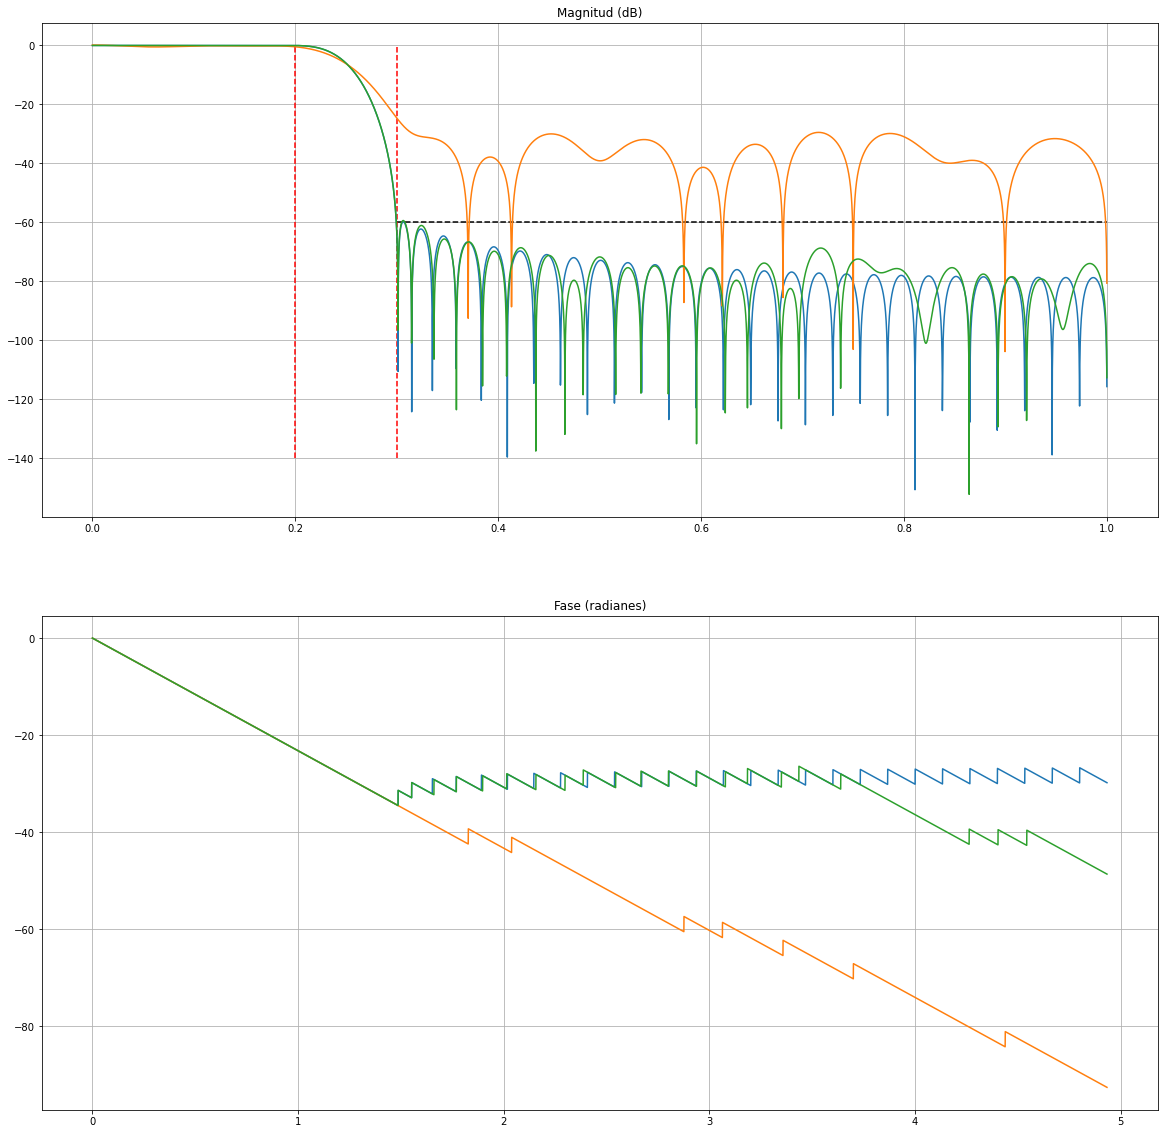

In [ ]:
from fxpoint._fixedInt import DeFixedInt
from fxpoint._fixedInt import arrayFixedInt
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

#Cargamos el filtro utilizando el archivo .npy
data = np.load('fir_win_kaiser.npz')
#Sacamos b,a
b = data['ba'][0]
#a es siempre 1 ya que estamos con un IIR
a = data['ba'][1]

b_fixed_1_7 = [(DeFixedInt(0,7,item,roundMode='trunc').value,DeFixedInt(0,7,item,roundMode='trunc').fValue) for item in b]
b_fixed_1_7_coefs = [item[1] for item in b_fixed_1_7]
b_fixed_1_7_int   = [item[0] for item in b_fixed_1_7]


b_fixed_1_15 = [(DeFixedInt(0,15,item,roundMode='trunc').value,DeFixedInt(0,15,item,roundMode='trunc').fValue) for item in b]
b_fixed_1_15_coefs = [item[1] for item in b_fixed_1_15]
b_fixed_1_15_int   = [item[0] for item in b_fixed_1_15]


w,h_fixed_1_7  = signal.freqz(b_fixed_1_7_coefs,1,worN = 8192)
w,h_fixed_1_15 = signal.freqz(b_fixed_1_15_coefs ,1,worN = 8192)
w,h_float      = signal.freqz(b,1,worN = 8192)


#Hacemos los plots
fig,ax = plt.subplots(2,figsize = (20,20))

ax[0].plot(w/np.pi,20*np.log10(np.abs(h_float)))
ax[0].plot(w/np.pi,20*np.log10(np.abs(h_fixed_1_7)))
ax[0].plot(w/np.pi,20*np.log10(np.abs(h_fixed_1_15)))
ax[0].hlines(-60,0.3,1.0,'k','dashed')
ax[0].vlines(0.2,-140,0.0,'r','dashed')
ax[0].vlines(0.3,-140,0.0,'r','dashed')
ax[0].grid()
ax[0].set_title("Magnitud (dB)")

ax[1].plot(w/2*np.pi,np.unwrap(np.angle(h_float)))
ax[1].plot(w/2*np.pi,np.unwrap(np.angle(h_fixed_1_7)))
ax[1].plot(w/2*np.pi,np.unwrap(np.angle(h_fixed_1_15)))
ax[1].grid()
ax[1].set_title("Fase (radianes)")